# AIR QUALITY PREDICTION IN LAGOS

## EXPLORATORY DATA ANALYSIS
- Load Libraries
- Load Dataset
- Overview of the dataset
- Clean Datasets
- Create a Wrangle Function
- Exploration on data

## Load Libraries

In [101]:
# Load Libraries

import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


## Load Dataset

In [145]:
# file directory
file= "../data/November_2023.csv"

# load into DataFrame
df = pd.read_csv(file, delimiter=';', index_col="timestamp")

# Show only PM2.5 readings
mask = df["value_type"] == "P2"
df = df[mask]

df.head()

,sensor_id,sensor_type,location,lat,lon,value_type,value
timestamp,,,,,,,
2023-11-01T16:44:52.764459+00:00,4855,pms5003,3629,6.428,3.435,P2,19.00
2023-11-01T17:52:08.924982+00:00,4857,pms5003,3630,6.540,3.297,P2,3.50
2023-11-01T17:53:13.805911+00:00,4857,pms5003,3630,6.540,3.297,P2,3.00
2023-11-01T18:16:42.515782+00:00,4853,pms5003,3628,6.559,3.386,P2,40.33
2023-11-03T07:38:39.664224+00:00,4857,pms5003,3630,6.540,3.297,P2,47.00


## Overview of the Dataset


In [146]:
# Size of the Dataset
shape = df.shape

print(f"The Shape of the Dataset is: {shape}")
print(f"The Dataset has: {shape[0]} historical data")
print(f"The dataset have {shape[1]} columns. For PM2.5 Readings")

The Shape of the Dataset is: (250, 7)
The Dataset has: 250 historical data
The dataset have 7 columns. For PM2.5 Readings


In [147]:
# Range of Data Records
start_date = df.index[-1]
end_date = df.index[0]

print(f"The dataset records is between {start_date} and {end_date}")

The dataset records is between 2023-11-27T08:19:48.370122+00:00 and 2023-11-01T16:44:52.764459+00:00


In [148]:
# Dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 2023-11-01T16:44:52.764459+00:00 to 2023-11-27T08:19:48.370122+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sensor_id    250 non-null    int64  
 1   sensor_type  250 non-null    object 
 2   location     250 non-null    int64  
 3   lat          250 non-null    float64
 4   lon          250 non-null    float64
 5   value_type   250 non-null    object 
 6   value        250 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 15.6+ KB
None


### Summary

- This Dataset covers for 3 years records.
- Starting from `April 2021` to `April 2023`
- Contains `665` observations
- There are no missing values in the dataset

## Exploratory Data Analysis

- clean dataset
- PM2.5 readings over time
- Rolling Statistics
- Histogram And Boxplots
- Seasonal Decomposition
- ACF and PACF plots

In [200]:
# Clean Dataset
df.index = pd.DatetimeIndex(df.index)

# Localize to Timezone
df.index = df.index.tz_convert("Africa/Lagos")

# rename the "pm25" Column to "PM2.5" for clarity
df = df.rename(columns={"value": "PM2.5"})

# Resample the readings to hour by hour. fill NaN values with forward fill methods
df = df["PM2.5"].resample("1h").mean().ffill().to_frame()

# rename the index column to date
df.index = df.index.rename("date")

# Sort the dates in ascending order
df = df.sort_index(ascending=True)

# missing data present in the dataset
missing = df.isna().sum()
print("Missing values:\n", missing)
print(f"The Shape of the dataset is: {df.shape}")

df.head()

Missing values:
 PM2.5    0
dtype: int64
The Shape of the dataset is: (617, 1)


,PM2.5
date,
2023-11-01 17:00:00+01:00,19.00
2023-11-01 18:00:00+01:00,3.25
2023-11-01 19:00:00+01:00,40.33
2023-11-01 20:00:00+01:00,40.33
2023-11-01 21:00:00+01:00,40.33


### Summary

- After using `df.asfreq("D")` to ensure that every day within the dataset date range has a data, it appears that there were `156 days` without data.
- Two options were considered for filling the missing data: `Fill Forward` and `Linear Interpolation`
- Finally, The The fill forward strategy was implemented. Leaving the dataset with no missing PM2.5 reading.

### PM2.5 Over time

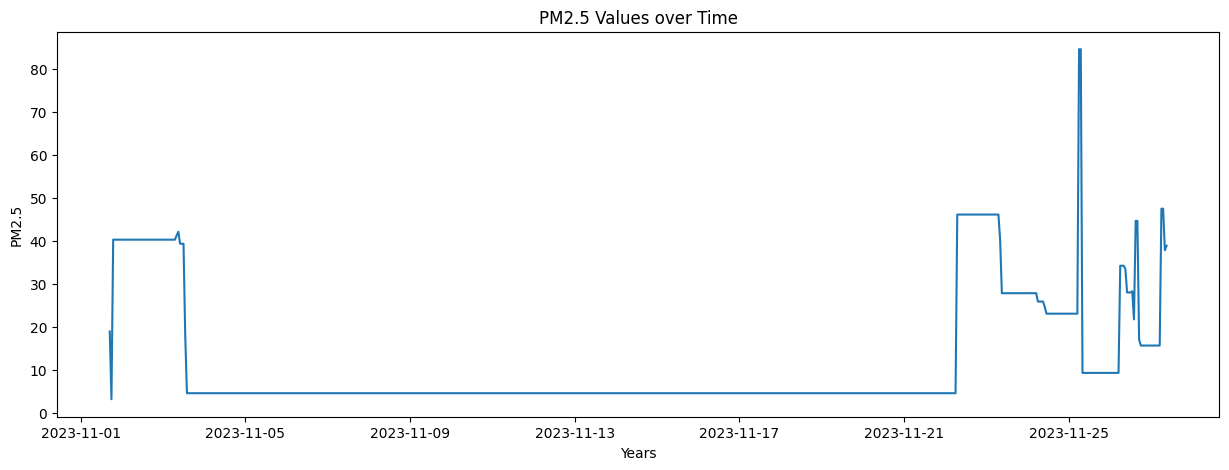

In [188]:
# PM2.5 Over time
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(df["PM2.5"])
plt.title("PM2.5 Values over Time")
plt.xlabel("Years")
plt.ylabel("PM2.5")
plt.show()

### Rolling Statistics
- Rolling average
- Rolling Standard deviation

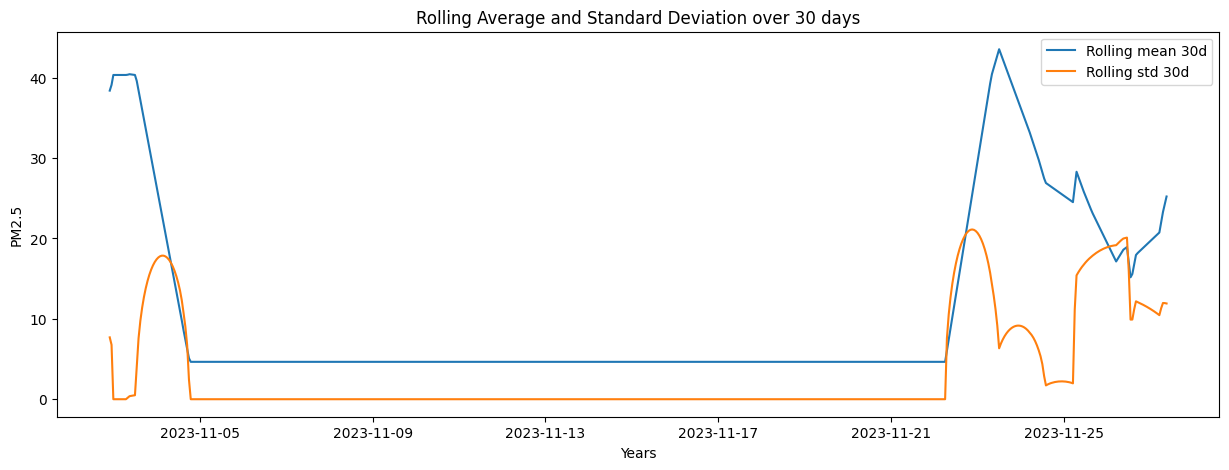

In [189]:
# rolling mean for 30 days
rolling_mean = df["PM2.5"].rolling(window= 30).mean()

# rolling variance for 30 days
rolling_std = df["PM2.5"].rolling(window = 30).std()

# Plot charts
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(rolling_mean, label = "Rolling mean 30d")
plt.plot(rolling_std, label = "Rolling std 30d")
plt.title("Rolling Average and Standard Deviation over 30 days")
plt.xlabel("Years")
plt.ylabel("PM2.5")

plt.legend()
plt.show()


### Histogram and Boxplot

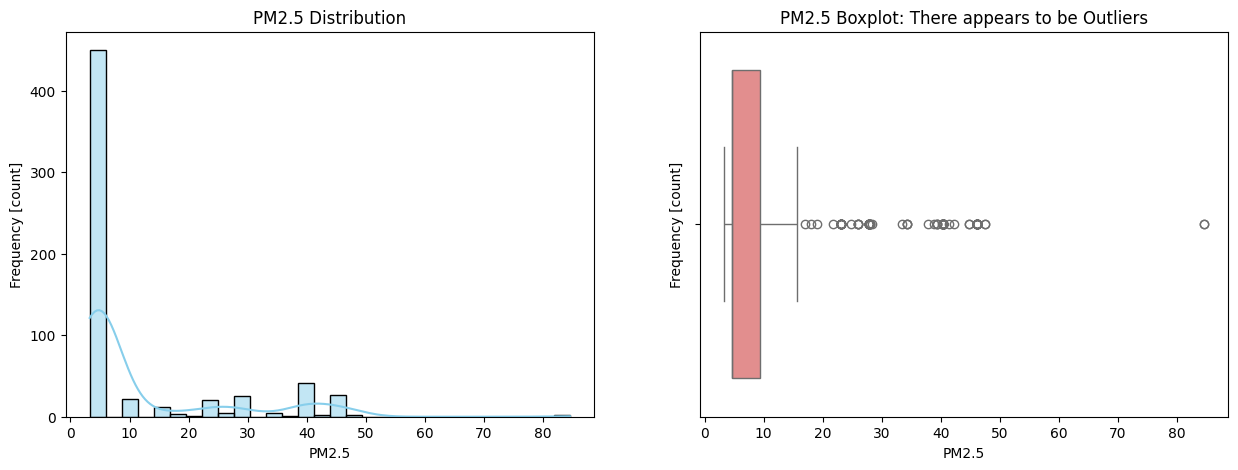

In [190]:
# Figure size
plt.figure(figsize= (15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df["PM2.5"], kde=True, bins =  30, color= "skyblue")
plt.title("PM2.5 Distribution")
plt.ylabel("Frequency [count]")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(df["PM2.5"], color= "lightcoral", orient="h")
plt.title("PM2.5 Boxplot: There appears to be Outliers")
plt.ylabel("Frequency [count]")

plt.show()

### Seasonal Decompose

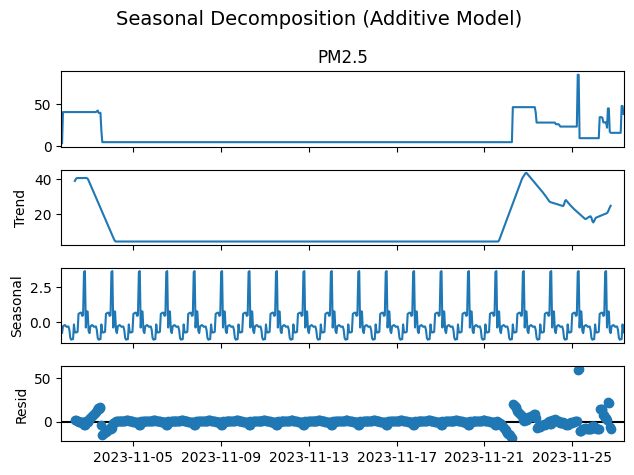

In [191]:
# Instantiate the seasonal_decompose
decomposition = seasonal_decompose(df["PM2.5"], model="additive", period=30)

# Plot the Chart
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Additive Model)", fontsize=14)
plt.tight_layout()
plt.show()

### ACF and PACF Plots


<Figure size 1400x500 with 0 Axes>

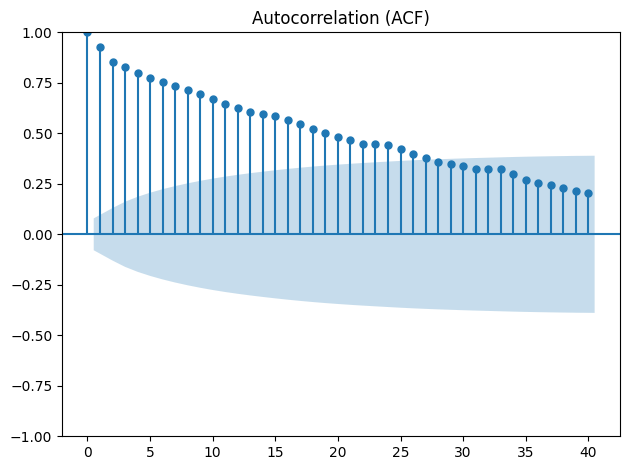

In [192]:
# plot_acf

plt.figure(figsize=(14, 5))
plot_acf(df["PM2.5"].dropna(), lags = 40)
plt.title("Autocorrelation (ACF)")
plt.tight_layout()
plt.show()

<Figure size 1400x500 with 0 Axes>

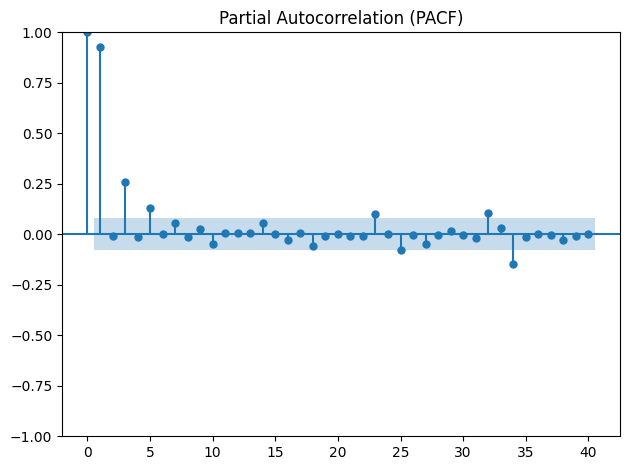

In [193]:
# plot_pacf

plt.figure(figsize=(14, 5))
plot_pacf(df["PM2.5"].dropna(), lags=40)
plt.title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

### Summary

- Abnormally Low PM2.5 Readings (e.g., ~0 in Jan 2022 and Jan 2023) which may be due to `Sensor malfunction or downtime`. Solution is to either: Leave them in (let the model learn spikes/drops) or Replace near-zero values with NaN and interpolate.
- **Histogram & Boxplot:** The Distribution is right-skewed, typical for pollution data. And we consider Outliers above 400 µg/m³ very extreme. solution: Cap using winsorization or Cap manually
- **Seasonal Decomposition:** There is clear seasonality — possibly monthly cycles due to climate or traffic. meanwhile, Trend is not constant — major spikes and declines.
- **ACF Plot:** Significant autocorrelation persists up to lag ~30. ARMA/ARIMA appears to be a great choice.
- **PACF Plot:** Shows a strong spike at lag 1, Then mostly dies out. This Suggests AR(1) or ARMA(1,q) could be a strong candidate, and beyond lag 1, there is little additional direct predictive value

In [194]:
# 5 Summary Metrics
df.describe()

,PM2.5
count,617.000000
mean,11.803956
std,13.765063
min,3.250000
25%,4.650000
50%,4.650000
75%,9.366429
max,84.590909


## Wrangle Function

- load all csv file
- clean them
- combine them
- save into a new csv file
  

In [207]:
def wrangle(filepath):
    # Load the dataset (semicolon-separated)
    df = pd.read_csv(filepath, delimiter=';', index_col='timestamp')

    # Filter only PM2.5 readings
    df = df[df['value_type'] == 'P2']

    # Convert index to datetime
    df.index = pd.to_datetime(df.index, errors='coerce')

    # Drop rows with invalid (NaT) timestamps
    df = df[~df.index.isna()]

    # Localize and convert time zone
    df.index = df.index.tz_convert('Africa/Lagos')

    # Rename column for clarity
    df.rename(columns={'value': 'PM2.5'}, inplace=True)

    # Resample to hourly frequency, forward fill
    df = df['PM2.5'].resample('1h').mean().ffill().to_frame()

    # Rename index to 'date'
    df.index.name = 'date'

    # Sort by date ascending
    df.sort_index(inplace=True)

    return df


In [208]:
df = wrangle(file)

df.head()

,PM2.5
date,
2023-11-01 17:00:00+01:00,19.00
2023-11-01 18:00:00+01:00,3.25
2023-11-01 19:00:00+01:00,40.33
2023-11-01 20:00:00+01:00,40.33
2023-11-01 21:00:00+01:00,40.33
